In [1]:
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Loading the data

In [2]:
data_path = "./data/"

ARDS_data = scipy.io.loadmat(data_path + "Ards.mat")
Control_data = scipy.io.loadmat(data_path + "Control.mat")

ARDS_data = {key: ARDS_data[key][0] for key in ["P", "Q", "V", "t"]}
Control_data = {key: Control_data[key][0] for key in ["P", "Q", "V", "t"]}

# Part 1 : make plots of the differents curves

In [3]:
def plot_time_curves(data, name = "Plot.png", title="Data",alpha_value = 0.5, x_label = "X", y_label ="Y", grid = True):
    P = data['P']
    V = data['V']
    Q = data['Q']
    t = data['t'] - data['t'][0]
    #Create the P-V loop
    plt.figure(1)
    print("---PV loop---")
    # Create a colormap that represents the gradient of time
    cmap = plt.cm.jet  # You can choose any colormap you prefer
    norm = plt.Normalize(min(t), max(t))
    ncolors = len(t)  # Number of colors should match the number of time points
    colors = cmap(norm(t))
    points = np.array([P, V]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection object with a color gradient
    lc = LineCollection(segments, cmap=ListedColormap(colors), norm=BoundaryNorm(t, ncolors), linewidth=2, alpha=alpha_value)
    lc.set_array(t)

    # Plot the trajectory
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.colorbar(lc, label='Time')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    minP = np.argmin(P)
    index_inspi = np.where(Q >= 0)[0]
    V_Q_0 = V[index_inspi[-1]]
    P_Q_0 = P[index_inspi[-1]]
    ax.plot([P[minP], P_Q_0],  [0, V_Q_0], label = 'Inspiration/Expiration Separation', color ="deepskyblue")
    ax.plot([P[minP], P[minP]], [0, V_Q_0], label = 'Limit of Elastic Work', color = "midnightblue", linestyle = 'dashed')
    ax.plot([P[minP], P_Q_0], [V_Q_0, V_Q_0], color = "midnightblue", linestyle = 'dashed')
    ax.legend(loc = 'lower right')
    plt.xlim(2,45)
    plt.ylim(-0.01, 0.31)
    plt.grid()
    plt.savefig(name, dpi = 150)
    plt.show()
    plt.figure(2)
    print("---VQ loop---")
    # Create a colormap that represents the gradient of time
    cmap = plt.cm.jet  # You can choose any colormap you prefer
    norm = plt.Normalize(min(t), max(t))
    ncolors = len(t)  # Number of colors should match the number of time points
    colors = cmap(norm(t))
    points = np.array([V, Q]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection object with a color gradient
    lc = LineCollection(segments, cmap=ListedColormap(colors), norm=BoundaryNorm(t, ncolors), linewidth=2, alpha=alpha_value)
    lc.set_array(t)

    # Plot the trajectory
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.colorbar(lc, label='Time')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    ax.plot([0,V_Q_0],  [0, 0], color ="deepskyblue", label ='Inspiration/Expiration Separation' )
    plt.scatter(V[np.argmin(Q)],np.min(Q), color = 'brown', label = 'Peak Expiratory Flow')
    plt.legend(loc = 'lower left')
    plt.xlim(-0.03, 0.33)
    plt.ylim(-1,0.6)
    plt.grid()
    plt.show()

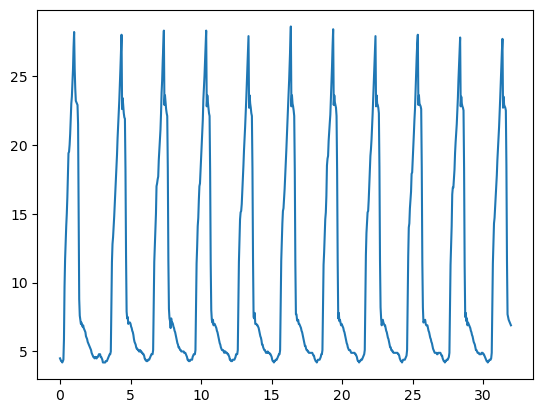

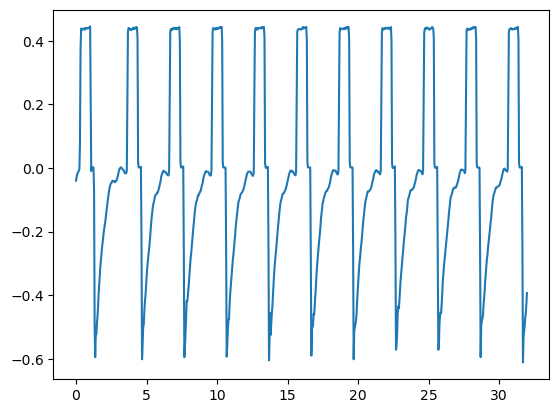

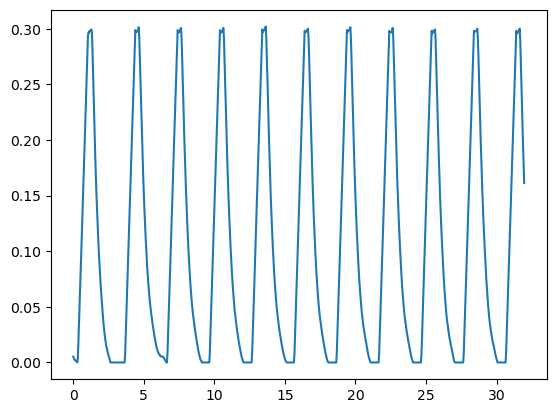

In [4]:
plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['P'], label="Control data")
plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['Q'], label="Control data")

plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['V'], label="Control data")

In [5]:
def extract_cycles(data):
    cycles = []

    t = data['t']
    P = data['P']
    Q = data['Q']
    V = data['V']

    zero_V_indices = np.argwhere(V == 0).flatten()
    filtered_V_indices = []

    if len(zero_V_indices) == 0:
        print("Not a proper curve ! Never cross V = 0")
        exit(-1)

    filtered_V_indices.append(zero_V_indices[0])

    for i in range(1, len(zero_V_indices)):
        if zero_V_indices[i] != zero_V_indices[i-1] + 1:
            filtered_V_indices.append(zero_V_indices[i])

    for i in range(0, len(filtered_V_indices) - 1):
        cycles.append({'t' : t[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'P' : P[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'Q' : Q[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'V' : V[filtered_V_indices[i]:filtered_V_indices[i+1]+1]})
    """
    plt.figure()
    plt.plot(t, V)
    for k in range(len(filtered_V_indices)):
        plt.axvline(t[filtered_V_indices[k]], color='red')
    plt.show()

    plt.figure()
    plt.plot(t, Q)
    for k in range(len(filtered_V_indices)):
        plt.axvline(t[filtered_V_indices[k]], color='red')
    plt.show()

    plt.figure()
    plt.plot(t, P)
    for k in range(len(filtered_V_indices)):
        plt.axvline(t[filtered_V_indices[k]], color='red')
    plt.show()
    """
    return cycles

In [6]:
def get_RIW_REW_EW(data):
    P = data['P']
    V = data['V']
    Q = data['Q']
    t = data['t'] - data['t'][0]

    minP = np.argmin(P)
    index_inspi = np.where(Q >= 0)[0]

    V_Q_0 = V[index_inspi[-1]]
    P_Q_0 = P[index_inspi[-1]]
    base = np.abs(P_Q_0 - P[minP])
    print(base)
    
    EW = (base * V_Q_0)/2

    P_expi = P[index_inspi[-1]:]
    V_expi = V[index_inspi[-1]:]   

    a,b = np.polyfit([P[minP], P_Q_0],  [0, V_Q_0], deg = 1)
    y = P_expi*a +b
    V_expi_adjusted = y-V_expi
    REW = np.abs(np.trapz(V_expi_adjusted, P_expi))
  
    RIW = np.abs(np.trapz(V, P)) -(REW)
    return RIW, REW, EW


In [7]:
def get_peak_expiratory_flow(data):
    Q = data['Q']
    return np.min(Q)

def get_tidal_volume(data):
    Q = data['Q']
    V = data['V']
    index_inspi = np.where(Q >= 0)[0]
    V_Q_0 = V[index_inspi[-1]]
    return V_Q_0

---PV loop---


<Figure size 640x480 with 0 Axes>

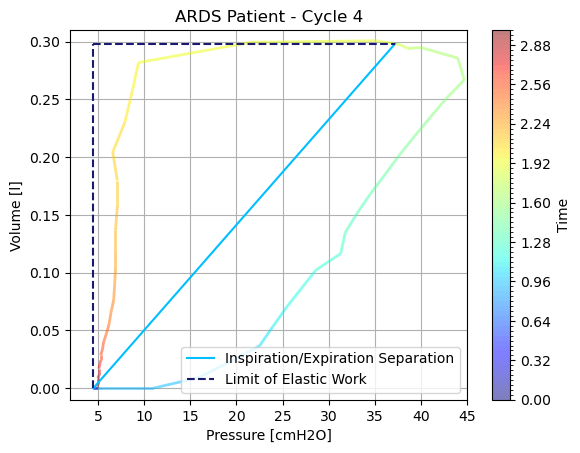

---VQ loop---


<Figure size 640x480 with 0 Axes>

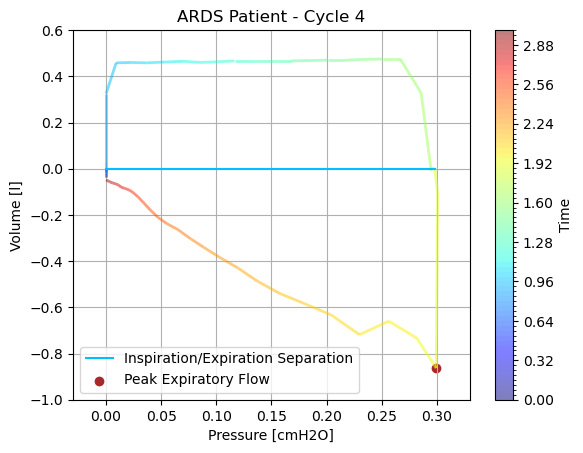

[-0.8666666666666667, -0.84, -0.8200000000000001, -0.8633333333333333, -0.85, -0.8350000000000001, -0.815, -0.8450000000000001, -0.8133333333333332, -0.8283333333333334] [0.2975, 0.2975, 0.2949, 0.29819999999999997, 0.2988, 0.2943, 0.29819999999999997, 0.2988, 0.2995, 0.2969]


In [8]:
cycles = extract_cycles(ARDS_data)
cycles2 = extract_cycles(Control_data)
plot_time_curves(cycles[3], grid = True, title = "ARDS Patient - Cycle 4", x_label= "Pressure [cmH2O]", y_label= "Volume [l]")
Qmin = []
tidal_volumes = []
for i in range(len(cycles)):
    Qmin.append(get_peak_expiratory_flow(cycles[i]))
    tidal_volumes.append(get_tidal_volume(cycles[i]))

print(Qmin, tidal_volumes)

In [9]:
from scipy.interpolate import interp1d

def from_data_get_interpolate(data):
    t = data['t']
    V = data['V']
    P = data['P']
    Q = data['Q']

    t_span = [min(t), max(t)]

    V_interp = interp1d(t, V, kind='linear', fill_value='extrapolate')
    P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
    Q_interp = interp1d(t, Q, kind='linear', fill_value='extrapolate')

    return t_span, V_interp, P_interp, Q_interp


In [10]:
from sklearn.linear_model import LinearRegression

def model(t, Ers, V, Rrs, Q, P0):
    return Ers*V(t) + Rrs * Q(t) + P0

def estimate_parameters(data):
    V = data['V']
    P = data['P']
    Q = data['Q']

    X = np.array([V, Q]).T
    Y = np.array(P)

    model = LinearRegression().fit(X, Y)
    
    Ers = model.coef_[0]
    Rrs = model.coef_[1]
    P0 = model.intercept_

    R_squared = model.score(X, Y)

    return Ers, Rrs, P0, R_squared

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def get_lung_properties(data):
    cycles = extract_cycles(data)
    #create a pandas dataframe with Ers, Rrs, P0, R_squared
    properties = pd.DataFrame(columns=['Ers', 'Rrs', 'P0', 'R_squared'])
    for c, d in enumerate(cycles):
        Ers, Rrs, P0, R_squared = estimate_parameters(d)
        properties.loc[c] = [Ers, Rrs, P0, R_squared]
    return properties

control_properties = get_lung_properties(Control_data)
#compute Q25, Q50 and Q75 and put in a dataframe
med_control_properties = control_properties.quantile([0.25, 0.5, 0.75])
ARDS_properties = get_lung_properties(ARDS_data)
med_ards_properties = ARDS_properties.quantile([0.25, 0.5, 0.75])
#print(control_properties)
#print(ARDS_properties)

print(min(control_properties['R_squared']), max(control_properties['R_squared']))
print(med_control_properties)
print(min(ARDS_properties['R_squared']), max(ARDS_properties['R_squared']))
print(med_ards_properties)

0.9827665109135536 0.9872013920768457
            Ers        Rrs        P0  R_squared
0.25  54.583235  16.676792  4.734757   0.983643
0.50  55.178957  16.821022  4.779001   0.984379
0.75  55.324919  16.989591  4.784016   0.985155
0.9828182750757103 0.9875450670969469
             Ers        Rrs        P0  R_squared
0.25  104.142661  26.021115  5.166231   0.984087
0.50  104.745358  26.198070  5.219899   0.986059
0.75  104.892127  26.600102  5.345834   0.987074


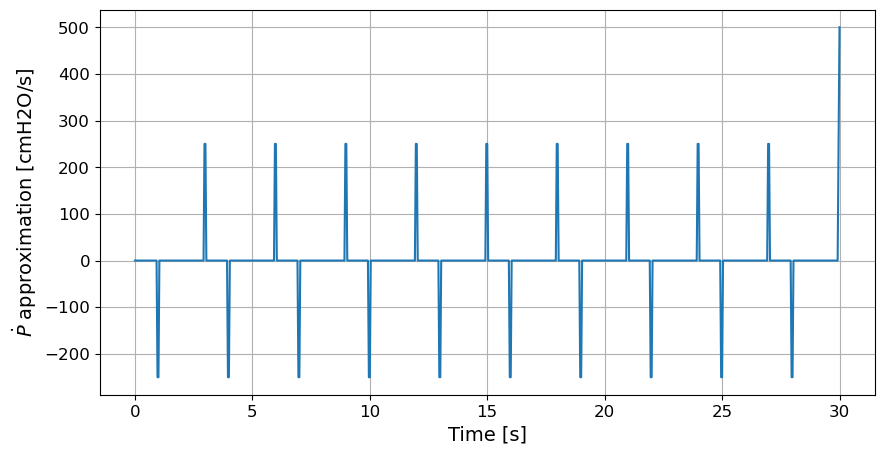

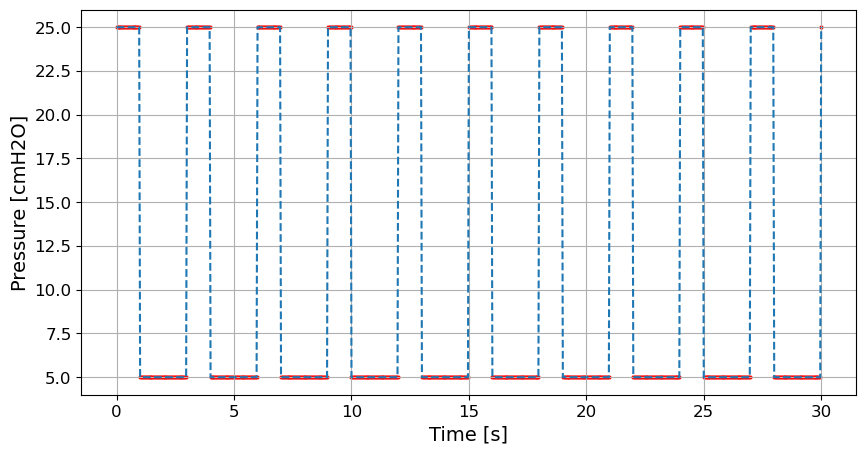

In [11]:
def square_wave(t, p_max=20, p_min=0, PEEP=5, BR_per_min=20, exp_ratio=2/3):
    # Compute the period of the square wave
    T = 60 / BR_per_min

    # Compute the time in the period
    t = t % T

    # Compute the time in the inspiration
    t_insp = T * (1-exp_ratio)

    # Compute the time in the expiration
    t_exp = T * exp_ratio

    # Compute the pressure
    if t < t_insp:
        return p_max + PEEP
    else:
        return p_min + PEEP
    
t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]

P_dot = np.gradient(P, t)
plt.figure(figsize=(10, 5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(t, P_dot)
plt.grid()
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel(r'$\dot{P} $ approximation [cmH2O/s]', fontsize=14)
plt.savefig('P_dot.png')
plt.figure(figsize=(10, 5))

plt.plot(t, P, '--')
plt.scatter(t, P, marker='x', s=4, color='r')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Pressure [cmH2O]', fontsize=14)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('square_wave.png')
plt.show()

[55.17895677722015, 16.82102228241495, 55.17895677722015, 16.82102228241495, 5]


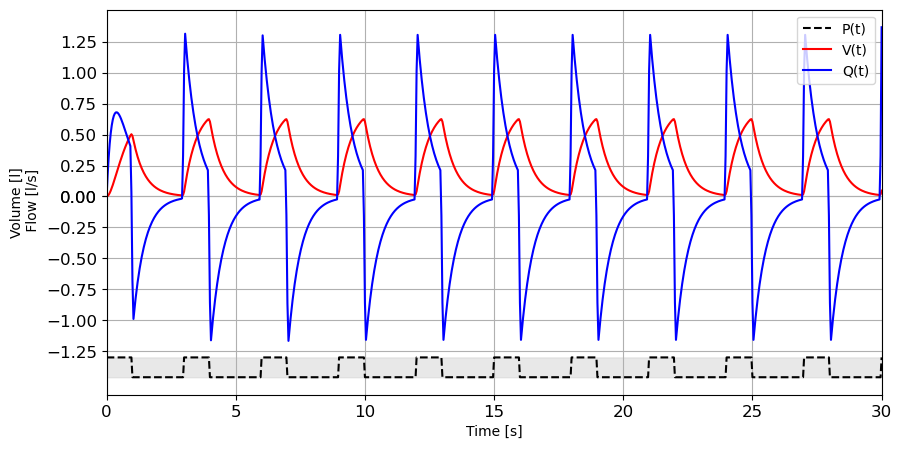

0.011694655473419196 0.6250096581770921 0.6133150027036729


In [12]:
def model(t, x, params):
    
    V = x[0]
    Q = x[1]

    E1 = params[0]
    R1 = params[1]
    E2 = params[2]
    R2 = params[3]
    Rc = params[4]
    P = params[5](t)
    P_dot = params[6](t)
    PEEP = params[7]

    dV = Q
    dQ = ( (R1 + R2)*P_dot + (E1 + E2) * (P - PEEP) - ((R2 + Rc)*E1 +(R1+Rc)*E2)*Q - E1*E2*V ) / (R1*R2 + Rc*(R1+R2))

    return [dV, dQ]


from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def simulate_cycle(t, P, params, initial_conditions, PEEP = 5):
    P_dot = np.gradient(P, t)
    P = interp1d(t, P, kind='linear', fill_value='extrapolate')
    P_dot = interp1d(t, P_dot, kind='linear', fill_value='extrapolate')
    params.append(P)
    params.append(P_dot)
    params.append(PEEP)
    t_span = [min(t), max(t)]
    sol = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t, max_step=0.04)
    return sol

t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]

params = [med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0]
print(params)
sol = simulate_cycle(t, P, params, initial_conditions)
# Calculate min and max of scaled P(t)
f = 0.2
y_offset = 1.5
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

# Plotting dashed P(t) with background fill
plt.figure(figsize=(10, 5))
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')

V_total = sol.y[0]
Q_total = sol.y[1]

plt.plot(sol.t, sol.y[0], label='V(t)', color='r')
plt.plot(sol.t, sol.y[1], label='Q(t)', color='b')

plt.xlim(min(t), max(t))

plt.xlabel('Time [s]')
plt.ylabel('Volume [l]\n Flow [l/s]')
plt.grid()

plt.legend(loc='best')
# Set y ticks from -0.5 to 0.9 with a step size of 0.1
plt.gca().set_yticks(list(np.arange(-1.25, 1.3, 0.25)) + [0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cycle_simulation.png')
plt.show()

print(min(V_total[len(V_total)//2:]), max(V_total[len(V_total)//2:]), max(V_total[len(V_total)//2:]) - min(V_total[len(V_total)//2:]))

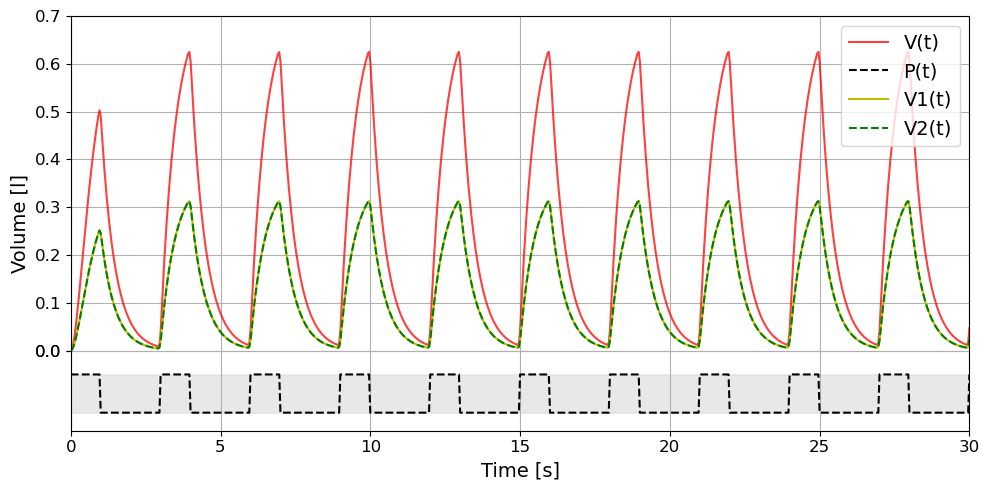

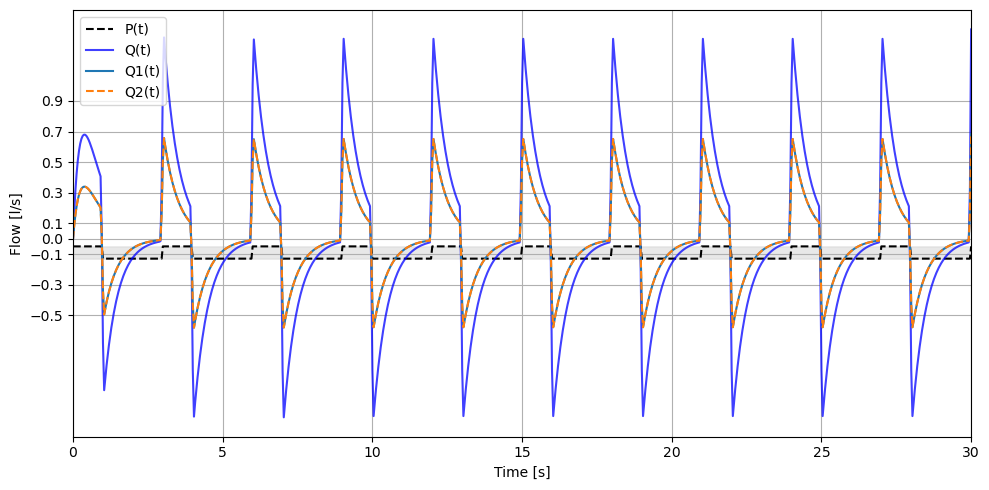

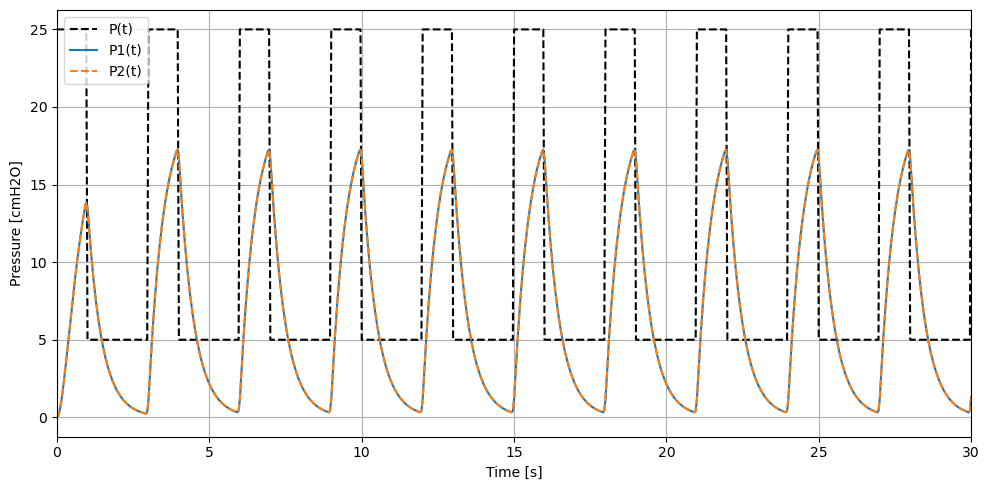

In [13]:
def lungs_model(t, x, params):

    V1 = x[0]
    Q1 = x[1]
    V2 = x[2]
    Q2 = x[3]

    E1 = params[0]
    R1 = params[1]
    E2 = params[2]
    R2 = params[3]
    Rc = params[4]
    P = params[5](t)
    P_dot = params[6](t)
    PEEP = params[7]

    dV1 = Q1
    dV2 = Q2

    dQ1 = ( R2*P_dot + (E2) * (P-PEEP) - ((R2 + Rc)*E1 +(R1+Rc)*E2)*Q1 - E1*E2*V1 ) / (R1*R2 + Rc*(R1+R2))
    dQ2 = ( R1*P_dot + (E1) * (P-PEEP) - ((R2 + Rc)*E1 +(R1+Rc)*E2)*Q2 - E1*E2*V2 ) / (R1*R2 + Rc*(R1+R2))

    return [dV1, dQ1, dV2, dQ2]

def simulate_lungs_cycle(t, P, params, initial_conditions, PEEP = 5):
    P_dot = np.gradient(P, t)
    P = interp1d(t, P, kind='linear', fill_value='extrapolate')
    P_dot = interp1d(t, P_dot, kind='linear', fill_value='extrapolate')
    params.append(P)
    params.append(P_dot)
    params.append(PEEP)
    t_span = [min(t), max(t)]
    sol = solve_ivp(lungs_model, t_span, initial_conditions, args=(params,), t_eval=t, max_step=0.04)
    return sol

t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
params = [med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0, 0, 0]
sol = simulate_lungs_cycle(t, P, params, initial_conditions)
# Calculate min and max of scaled P(t)
f = 0.1
y_offset = 0.15
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

# Plot for volumes
plt.figure(figsize=(10, 5))
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(sol.t, V_total, label='V(t)', color='r', alpha=0.75)
plt.plot(t, [p for p in scaled_P], 'k--', label='P(t)')
plt.plot(sol.t, sol.y[0], label='V1(t)', color='y')
plt.plot(sol.t, sol.y[2], label='V2(t)', color='g', linestyle='--')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Volume [l]', fontsize=14)
plt.grid()
plt.legend(loc='best', fontsize=14)
# Set y ticks from -0.5 to 0.9 with a step size of 0.1
plt.gca().set_yticks(list(np.arange(0, 0.8, 0.1)) + [0])
plt.xlim(min(t), max(t))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('volumes_plot.png')
plt.show()

# Plot for flux
plt.figure(figsize=(10, 5))
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')
plt.plot(sol.t, Q_total, label='Q(t)', color='b', alpha=0.75)
plt.plot(sol.t, sol.y[1], label='Q1(t)')
plt.plot(sol.t, sol.y[3], label='Q2(t)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Flow [l/s]')
plt.grid()
plt.legend(loc='best')
plt.xlim(min(t), max(t))
plt.tight_layout()
plt.savefig('flux_plot.png')
# Set y ticks from -0.5 to 0.9 with a step size of 0.1
plt.gca().set_yticks(list(np.arange(-0.5, 1.0, 0.2)) + [0])
plt.show()

# Plot for pressure
plt.figure(figsize=(10, 5))
plt.plot(sol.t, [params[5](t) for t in sol.t], label='P(t)', color='k', linestyle='--')
plt.plot(sol.t, sol.y[0] * params[0], label='P1(t)')
plt.plot(sol.t, sol.y[2] * params[2], label='P2(t)', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [cmH2O]')
plt.grid()
plt.legend(loc='best')
plt.xlim(min(t), max(t))
plt.tight_layout()
plt.savefig('pressure_plot.png')
plt.show()

# Healthy VS ARDS Lung 

[104.74535773566478, 26.198070377048456, 55.17895677722015, 16.82102228241495, 5]


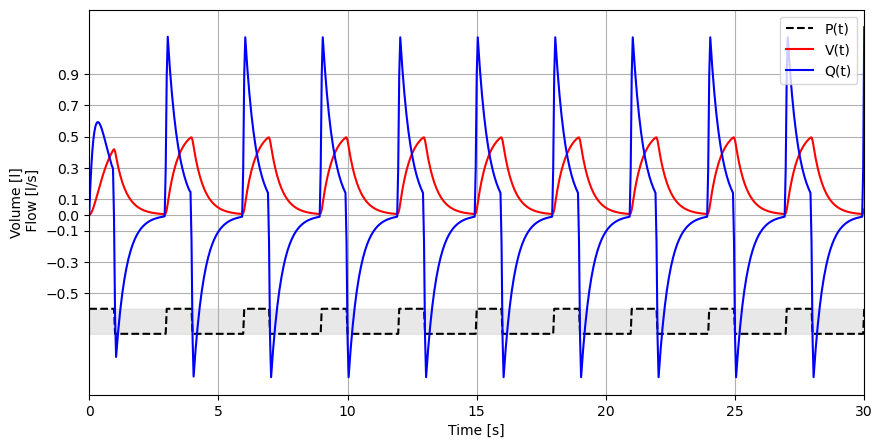

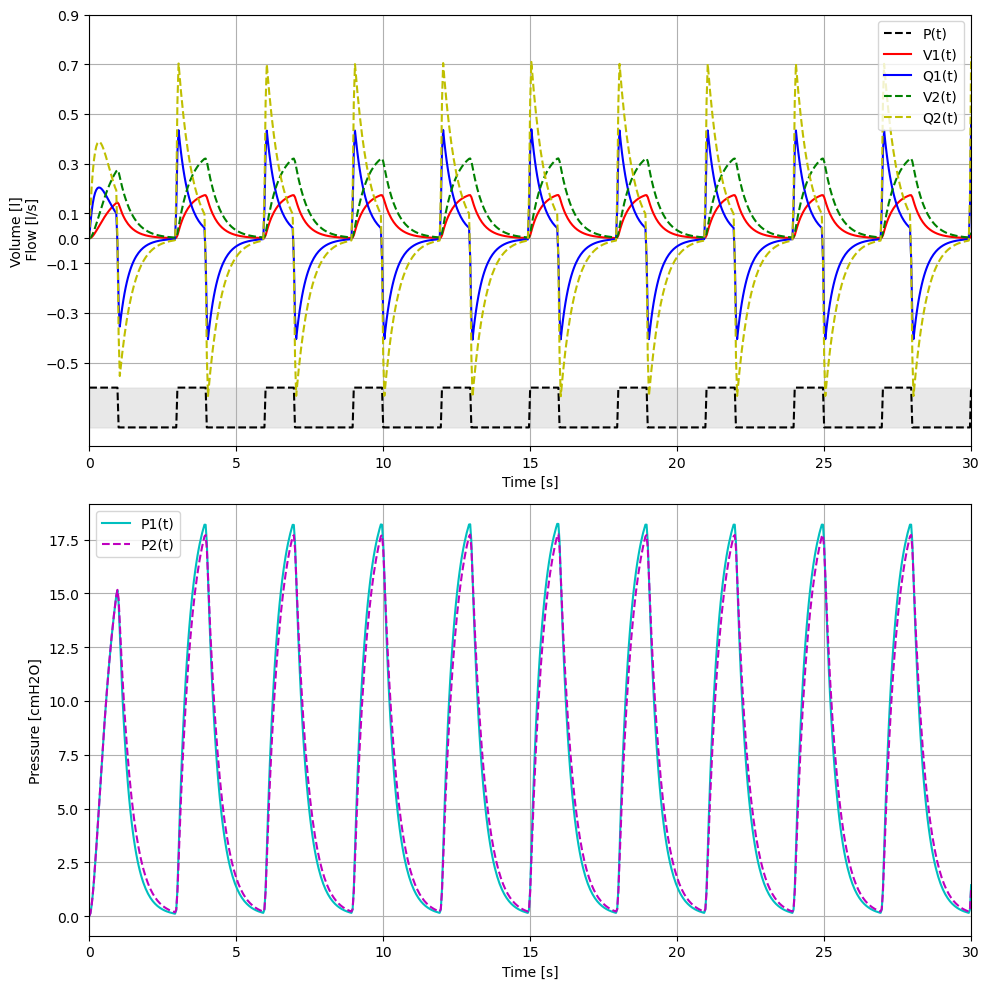

In [14]:
t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
params = [med_ards_properties.loc[0.5, 'Ers'], med_ards_properties.loc[0.5, 'Rrs'], med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0]
print(params)
sol = simulate_cycle(t, P, params, initial_conditions)

# Calculate min and max of scaled P(t)
f = 0.2
y_offset = 0.8
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

# Plotting dashed P(t) with background fill
plt.figure(figsize=(10, 5))
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')
plt.plot(sol.t, sol.y[0], label='V(t)', color='r')
plt.plot(sol.t, sol.y[1], label='Q(t)', color='b')
plt.xlim(min(t), max(t))
plt.xlabel('Time [s]')
plt.ylabel('Volume [l]\n Flow [l/s]')
plt.grid()
plt.legend(loc='best')
# Set y ticks from -0.5 to 0.9 with a step size of 0.1
plt.gca().set_yticks(list(np.arange(-0.5, 1.0, 0.2)) + [0])
plt.savefig('cycle_simulation_ards.png')
plt.show()

t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
params = [med_ards_properties.loc[0.5, 'Ers'], med_ards_properties.loc[0.5, 'Rrs'], med_control_properties.loc[0.5, 'Ers'], med_control_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0, 0, 0]
sol = simulate_lungs_cycle(t, P, params, initial_conditions)
# Calculate min and max of scaled P(t)
f = 0.2
y_offset = 0.8
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

plt.figure(figsize=(10, 10))

# First subplot
plt.subplot(2, 1, 1)
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')
plt.plot(sol.t, sol.y[0], label='V1(t)', color='r')
plt.plot(sol.t, sol.y[1], label='Q1(t)', color='b')
plt.plot(sol.t, sol.y[2], label='V2(t)', color='g', linestyle='--')
plt.plot(sol.t, sol.y[3], label='Q2(t)', color='y', linestyle='--')
plt.gca().set_yticks(list(np.arange(-0.5, 1.0, 0.2)) + [0])
plt.xlabel('Time [s]')
plt.ylabel('Volume [l]\n Flow [l/s]')
plt.grid()
plt.legend(loc='best')
plt.xlim(min(t), max(t))

# Second subplot
plt.subplot(2, 1, 2, sharex=plt.gca())  # Using sharex to share the x-axis
plt.plot(sol.t, sol.y[0]*params[0], label='P1(t)', color='c')
plt.plot(sol.t, sol.y[2]*params[2], label='P2(t)', color='m', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [cmH2O]')
plt.grid()
plt.legend(loc='best')
plt.xlim(min(t), max(t))

plt.tight_layout()
plt.savefig('lungs_simulation_ards.png')
plt.show()

# Both ARDS

[104.74535773566478, 26.198070377048456, 104.74535773566478, 26.198070377048456, 5]


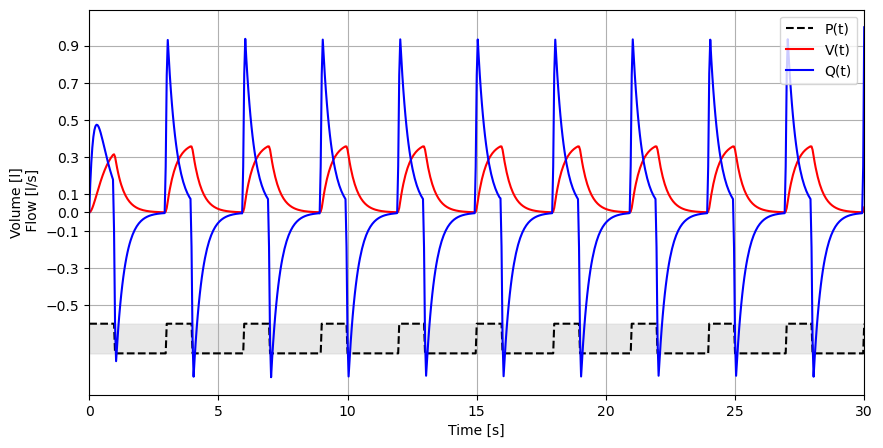

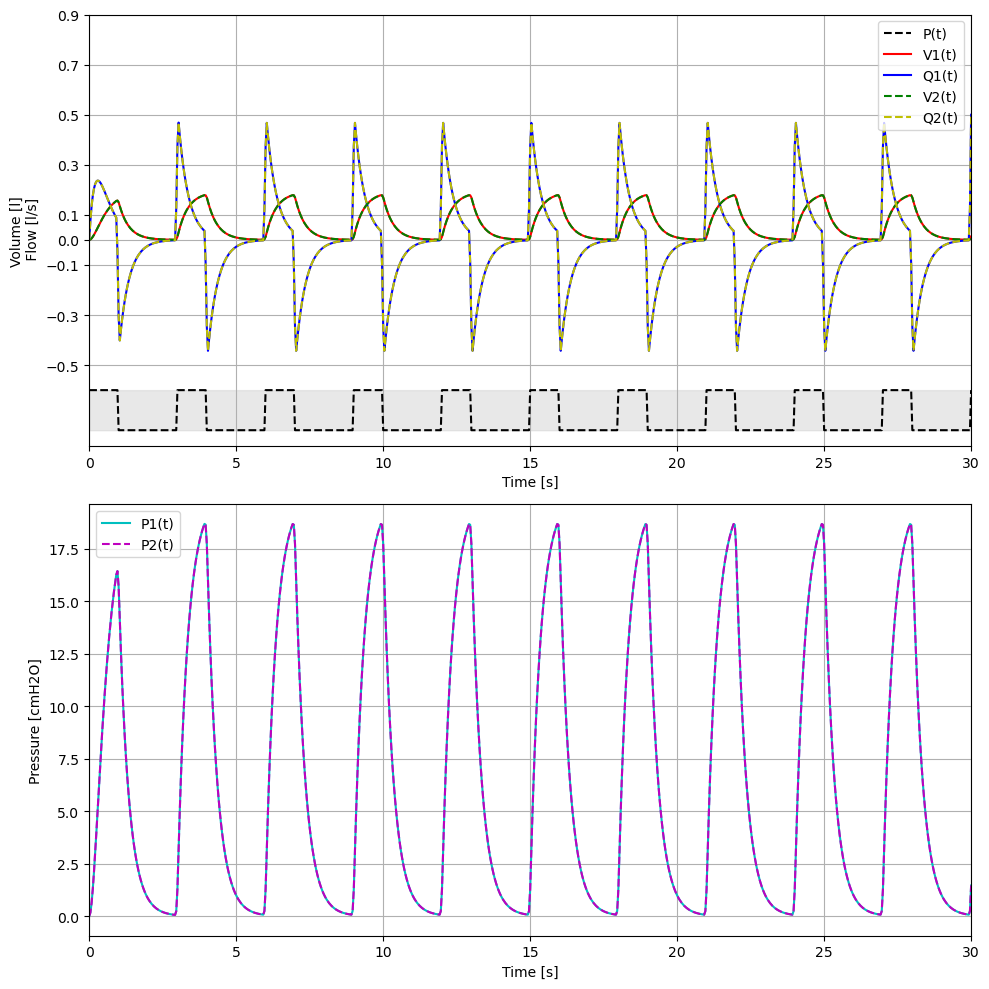

In [15]:
t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
params = [med_ards_properties.loc[0.5, 'Ers'], med_ards_properties.loc[0.5, 'Rrs'], med_ards_properties.loc[0.5, 'Ers'], med_ards_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0]
print(params)
sol = simulate_cycle(t, P, params, initial_conditions)

# Calculate min and max of scaled P(t)
f = 0.2
y_offset = 0.8
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

# Plotting dashed P(t) with background fill
plt.figure(figsize=(10, 5))
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')
plt.plot(sol.t, sol.y[0], label='V(t)', color='r')
plt.plot(sol.t, sol.y[1], label='Q(t)', color='b')
plt.xlim(min(t), max(t))
plt.xlabel('Time [s]')
plt.ylabel('Volume [l]\n Flow [l/s]')
plt.grid()
plt.legend(loc='best')
# Set y ticks from -0.5 to 0.9 with a step size of 0.1
plt.gca().set_yticks(list(np.arange(-0.5, 1.0, 0.2)) + [0])
plt.savefig('cycle_simulation_ards.png')
plt.show()

t = np.arange(0, 30.001, 0.04)
P = [square_wave(x) for x in t]
params = [med_ards_properties.loc[0.5, 'Ers'], med_ards_properties.loc[0.5, 'Rrs'], med_ards_properties.loc[0.5, 'Ers'], med_ards_properties.loc[0.5, 'Rrs'], 5]
initial_conditions = [0, 0, 0, 0]
sol = simulate_lungs_cycle(t, P, params, initial_conditions)
# Calculate min and max of scaled P(t)
f = 0.2
y_offset = 0.8
scaled_P = [f*p/np.max(P) - y_offset for p in P]
min_scaled_P = min(scaled_P)
max_scaled_P = max(scaled_P)

plt.figure(figsize=(10, 10))

# First subplot
plt.subplot(2, 1, 1)
plt.fill_between(t, min_scaled_P, max_scaled_P, color='lightgrey', alpha=0.5)
plt.plot(t, scaled_P, 'k--', label='P(t)')
plt.plot(sol.t, sol.y[0], label='V1(t)', color='r')
plt.plot(sol.t, sol.y[1], label='Q1(t)', color='b')
plt.plot(sol.t, sol.y[2], label='V2(t)', color='g', linestyle='--')
plt.plot(sol.t, sol.y[3], label='Q2(t)', color='y', linestyle='--')
plt.gca().set_yticks(list(np.arange(-0.5, 1.0, 0.2)) + [0])
plt.xlabel('Time [s]')
plt.ylabel('Volume [l]\n Flow [l/s]')
plt.grid()
plt.legend(loc='best')
plt.xlim(min(t), max(t))

# Second subplot
plt.subplot(2, 1, 2, sharex=plt.gca())  # Using sharex to share the x-axis
plt.plot(sol.t, sol.y[0]*params[0], label='P1(t)', color='c')
plt.plot(sol.t, sol.y[2]*params[2], label='P2(t)', color='m', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Pressure [cmH2O]')
plt.grid()
plt.legend(loc='best')
plt.xlim(min(t), max(t))

plt.tight_layout()
plt.savefig('lungs_simulation_ards.png')
plt.show()